In [1]:
pip install contractions

     |████████████████████████████████| 284 kB 3.0 MB/s 
     |████████████████████████████████| 106 kB 51.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import gensim
import contractions
from bs4 import BeautifulSoup
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
from matplotlib import pyplot as plt
import random

In [3]:
from nltk.corpus import gutenberg
nltk.download('gutenberg')
nltk.download('stopwords')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

### Loading Corpus

In [5]:
books_list = ['chesterton-thursday.txt', 'edgeworth-parents.txt',  'austen-sense.txt',  'whitman-leaves.txt',  'milton-paradise.txt']

In [6]:
for i, books in enumerate(books_list):
    locals()["book_"+ str(i)]= gutenberg.raw(books) 

### Data cleaning 


In [114]:
book_0[0:1000]

'[The Man Who Was Thursday by G. K. Chesterton 1908]\n\nTo Edmund Clerihew Bentley\n\nA cloud was on the mind of men, and wailing went the weather,\nYea, a sick cloud upon the soul when we were boys together.\nScience announced nonentity and art admired decay;\nThe world was old and ended: but you and I were gay;\nRound us in antic order their crippled vices came--\nLust that had lost its laughter, fear that had lost its shame.\nLike the white lock of Whistler, that lit our aimless gloom,\nMen showed their own white feather as proudly as a plume.\nLife was a fly that faded, and death a drone that stung;\nThe world was very old indeed when you and I were young.\nThey twisted even decent sin to shapes not to be named:\nMen were ashamed of honour; but we were not ashamed.\nWeak if we were and foolish, not thus we failed, not thus;\nWhen that black Baal blocked the heavens he had no hymns from us\nChildren we were--our forts of sand were even as weak as eve,\nHigh as they went we piled the

In [8]:
def partition_and_label(book, label):
    book_tokens= book.split()
    end= 150
    start=0
    book_sent = []
    partitions= []
    labeled_part=[]
    for i in range(0, len(book_tokens), end):
        book_sent.append(book_tokens[i:end])
        end+= 150
        random.seed(2)
    samples_200 = random.sample(book_sent, 200)
    for sentences in samples_200:
        partitions.append(" ".join(sentences))
    for partition in partitions:
        labeled_part.append([partition, label])
    return labeled_part

In [9]:
# Called functions to make a partition in the data and label them.
# Also combined all the texts and labels in one data frame.
n=5 
temp=[]
for i in range(n):
    locals()["partition_"+str(i)]= partition_and_label(locals()["book_"+str(i)], books_list[i].split("-")[0])
    if len(temp)<=1000:
        locals()["final_df_" +str(i)] = pd.DataFrame(locals()["partition_"+ str(i)],columns=["Text", "Label"])
        temp.append(locals()["final_df_" +str(i)])
        data = pd.concat(temp)
data.reset_index(drop= "index" , inplace= True)

In [10]:
data.head()

,Text,Label
0,"joke. Accepting the vein of humour, he said, w...",chesterton
1,"in an inhuman voice. ""Yes,"" said Syme simply, ...",chesterton
2,"a sandwich case, and a formidable flask of bra...",chesterton
3,"presence of a police officer, who explained th...",chesterton
4,"in their mouths""--and the policeman lowered hi...",chesterton


In [11]:
data.tail()

,Text,Label
995,"all day long Rove idle, unemployed, and less n...",milton
996,"our task In Heaven, this our delight. How wear...",milton
997,"passed, And all about found desolate; for thos...",milton
998,"but, till more hands Aid us, the work under ou...",milton
999,"and see!the guards, By me encamped on yonder h...",milton


## Shuffled data

In [12]:
data= data.sample(frac=1).reset_index(drop= True)
data.head()

,Text,Label
0,"was all they knew, and even this was some comf...",edgeworth
1,"one he stood escaped from cruel fight, Sore to...",milton
2,and frivolous part demanded of him by Presiden...,chesterton
3,"it been ten, Elinor would have been convinced ...",austen
4,only destroys because it broadens. A man's bra...,chesterton


In [13]:
data['Label'].value_counts()

edgeworth     200
milton        200
chesterton    200
austen        200
whitman       200
Name: Label, dtype: int64

## Data Cleaning / Data Pre-processing

In [14]:
clean_text = []
stopwords= stopwords.words('english')
for line in data['Text'].values:
    # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
    line = re.sub(r"http\S+", "", line)
    # https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
    line = BeautifulSoup(line, 'lxml').get_text()
    line = contractions.fix(line)
    #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    line = re.sub("\S*\d\S*", "", line).strip()
    #remove special character: https://stackoverflow.com/a/5843547/4084039
    line = re.sub('[^A-Za-z]+', ' ', line)
    #remove all the words which often seen common from the sentences
    # https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
    line = ' '.join(e.lower() for e in line.split() if e.lower() not in stopwords)
    clean_text.append(line.strip()) 

## Clean Data

In [15]:
clean_data= pd.DataFrame(clean_text, columns= ['Text'])
clean_data['Author_label']= data['Label']
clean_data.head()

,Text,Author_label
0,knew even comfort rose good friend pleasure te...,edgeworth
1,one stood escaped cruel fight sore toiled rive...,milton
2,frivolous part demanded president sunday indee...,chesterton
3,ten elinor would convinced moment heard carria...,austen
4,destroys broadens man brain bomb cried looseni...,chesterton


In [16]:
labelen = LabelEncoder()
labelencoded= labelen.fit_transform(clean_data['Author_label'])
clean_data['Label_Encoded']= pd.DataFrame(data= labelencoded, columns= ['Label_Encoded'])

In [17]:
clean_data.head()

,Text,Author_label,Label_Encoded
0,knew even comfort rose good friend pleasure te...,edgeworth,2
1,one stood escaped cruel fight sore toiled rive...,milton,3
2,frivolous part demanded president sunday indee...,chesterton,1
3,ten elinor would convinced moment heard carria...,austen,0
4,destroys broadens man brain bomb cried looseni...,chesterton,1


## Feature engineering

In [18]:
def feature_eng(method_name, n_gram, data):
    if method_name== 'BOW' and n_gram== False:
        BOW_1 = CountVectorizer()  
        vectorized= BOW_1.fit_transform(data)
    elif method_name== 'BOW with N-gram' and n_gram== True:
        BOW_2 = CountVectorizer(ngram_range= (1,2))
        vectorized= BOW_2.fit_transform(data)
    elif method_name== 'TFIDF' and n_gram== False:
        TFIDF_1 = TfidfVectorizer()
        vectorized= TFIDF_1.fit_transform(data)
    elif method_name== 'TFIDF with N-gram' and n_gram== True:
        TFIDF_2 = TfidfVectorizer(ngram_range= (1,2))
        vectorized= TFIDF_2.fit_transform(data)
    return vectorized
    

In [19]:
def plot(method,boolean):
    data = clean_data['Text'].values
    vec_1 =feature_eng(''+str(method),boolean, data) 
    X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(vec_1)
    temp = px.scatter(X_embedded, x= 0, y= 1, color= clean_data['Author_label'], title= ''+str(method))
    return temp,X_embedded

In [20]:
plot1, TFIDF_embeddings = plot('TFIDF', False)
plot1

In [21]:
plot2, TFIDF_ngram_embeddings = plot('TFIDF with N-gram', True)
plot2

In [22]:
plot3, BOW_embeddings = plot('BOW', False)
plot3

In [23]:
plot4, BOW_ngram_embeddings = plot('BOW with N-gram', True)
plot4

In [100]:
def kmeans(feat_method,name):
    kmeans = KMeans(n_clusters=5,random_state = 0).fit(feat_method)
    y_kmeans = kmeans.predict(feat_method)
    data = feat_method
    plt.figure(figsize=(14,9))
    plt.scatter(data[:,0], data[:,1], c=y_kmeans) 
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:,0], centers[:,1], marker='x', s=150, linewidths=3, c='r')
    plt.title(' '+str(name))
    temp = plt.show()
    return temp, y_kmeans

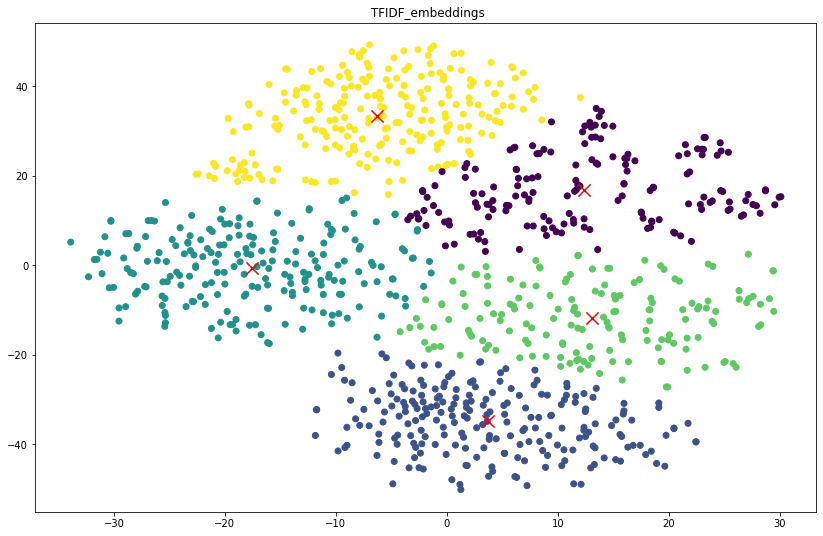

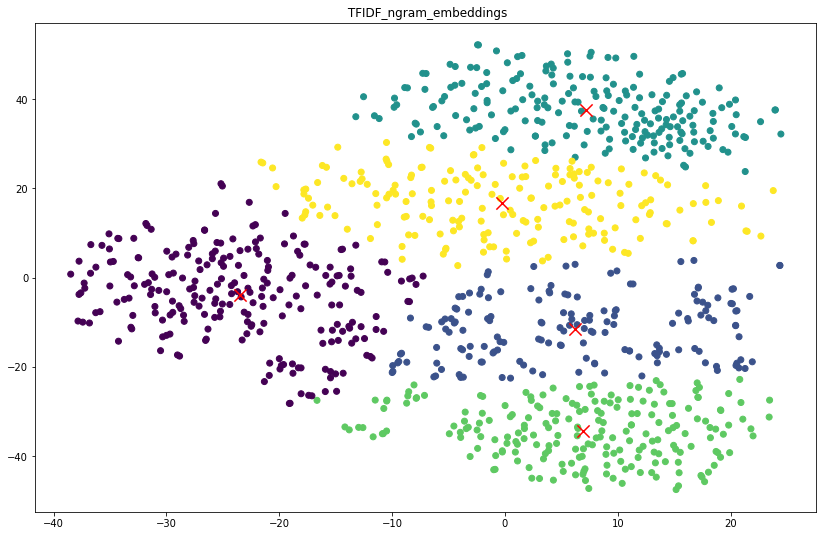

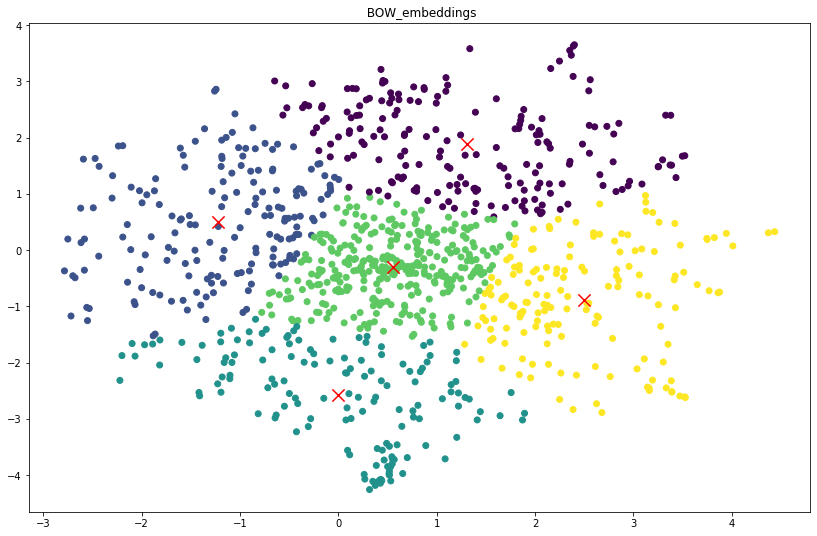

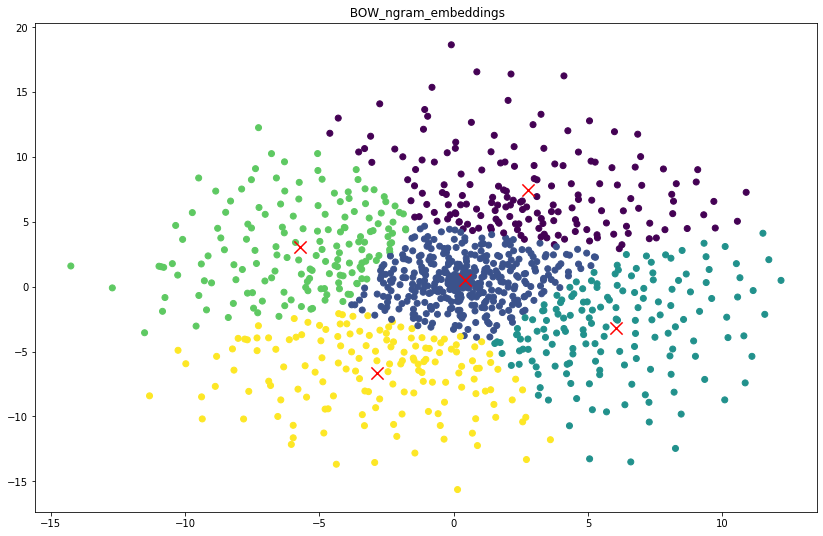

In [111]:
methods= [TFIDF_embeddings,TFIDF_ngram_embeddings,BOW_embeddings,BOW_ngram_embeddings]
names= ['TFIDF_embeddings','TFIDF_ngram_embeddings','BOW_embeddings','BOW_ngram_embeddings']
y_means_arr= []
for method in range(len(methods)):
    plot, y_means = kmeans(methods[method], names[method]) 
    y_means_arr.append(y_means)

In [98]:
n= ['TFIDF_embeddings','TFIDF_ngram_embeddings','BOW_embeddings','BOW_ngram_embeddings']
for i in range(len(n)):
    clusters = y_means_arr[i]
    print(" "+str(n[i]))
    for index,count in enumerate(np.bincount(clusters)):
        print("Number of samples clustered with centroid {} is :{}".format(index,count))
    print(" ")
print("A perfect cluster should contain 200 samples.")
print("Because there are five labels that contains 200 samples each")

 TFIDF_embeddings
Number of samples clustered with centroid 0 is :169
Number of samples clustered with centroid 1 is :222
Number of samples clustered with centroid 2 is :215
Number of samples clustered with centroid 3 is :162
Number of samples clustered with centroid 4 is :232
 
 TFIDF_ngram_embeddings
Number of samples clustered with centroid 0 is :235
Number of samples clustered with centroid 1 is :162
Number of samples clustered with centroid 2 is :207
Number of samples clustered with centroid 3 is :211
Number of samples clustered with centroid 4 is :185
 
 BOW_embeddings
Number of samples clustered with centroid 0 is :190
Number of samples clustered with centroid 1 is :174
Number of samples clustered with centroid 2 is :148
Number of samples clustered with centroid 3 is :332
Number of samples clustered with centroid 4 is :156
 
 BOW_ngram_embeddings
Number of samples clustered with centroid 0 is :166
Number of samples clustered with centroid 1 is :363
Number of samples clustered wi

In [80]:
# next, AgglomerativeClustering 